In [37]:
import numpy as np
import matplotlib.pyplot as plt

from algorithm import SGD
from optimizers import *
from loss import MSE, CrossEntropyLoss
from models import CustomLinearRegression, LogisticRegressionBC

In [38]:
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, accuracy_score, roc_curve
from sklearn.datasets import load_breast_cancer

In [39]:
import warnings
warnings.filterwarnings("ignore")

# Linear Regression on Real Estate Dataset

In [40]:
import pandas as pd

data = pd.read_csv("Realestate.csv", index_col=0)
data.head(3)

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
No,,,,,,,
1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3


In [41]:
# Split data on features and target

target_col = "Y house price of unit area"

y = data[target_col].to_numpy()
X = data.drop(columns=[target_col]).to_numpy()

X.shape, y.shape

((414, 6), (414,))

In [207]:
# Train-test split and standartize data with StandartScaler

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)

scaler = StandardScaler() 

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_offset = y_train.mean()
y_train -= y_offset
y_test -= y_offset

len(y_train), len(y_test), scaler.mean_, scaler.scale_

(372,
 42,
 array([2013.15345968,   17.67930108, 1109.38861022,    4.0483871 ,
          24.96902995,  121.53292599]),
 array([2.80966699e-01, 1.12748949e+01, 1.28172139e+03, 2.94260922e+00,
        1.25424518e-02, 1.54887148e-02]))

In [208]:
mse = MSE()

In [213]:
# Apply sklearn model

lm = LinearRegression()

lm.fit(X_train, y_train)

base_preds = lm.predict(X_test)

base_mse_score = mse.compute(base_preds, y_test)
base_r2_score = r2_score(y_test, base_preds)
print(f"Sklearn model mse = {base_mse_score}, r2_score = {base_r2_score}")

## Another way to compute r2 score
print(f"Inner way to compute r2 = {lm.score(X_test, y_test)}")

Sklearn model mse = 38.598247910237994, r2_score = 0.7470218557987665
Inner way to compute r2 = 0.7470218557987665


In [214]:
## Apply another SGD sklearn linear model 
lm = SGDRegressor(alpha=1e-4, max_iter=int(1e5), penalty=None, tol=1e-5, epsilon=1e-5, n_iter_no_change=20)

lm.fit(X_train, y_train)

base_preds = lm.predict(X_test)

base_mse_score = mse.compute(base_preds, y_test)
base_r2_score = r2_score(y_test, base_preds)
print(f"Sklearn model mse = {base_mse_score}, r2_score = {base_r2_score}")

## Another way to compute r2 score
print(f"Inner way to compute r2 = {lm.score(X_test, y_test)}")

Sklearn model mse = 38.6329614833679, r2_score = 0.7467943383391806
Inner way to compute r2 = 0.7467943383391806


My model mse = 38.24, r2 = 0.75


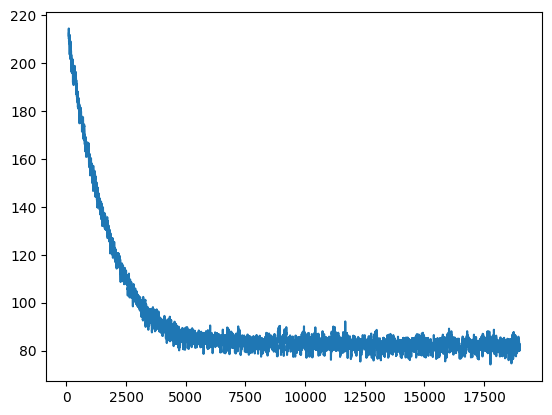

In [215]:
# Init My model and optimizer
my_lm = CustomLinearRegression(6)

opt = Adam()
opt.set_learning_params(my_lm.weights)

# Apply My custom Linear Regression

loss_history = SGD(X_train, y_train, my_lm, mse, opt=opt, 
                   batch_size=20, 
                   n_epochs=1000)


my_preds = my_lm.predict(X_test)
base_mse_score = mse.compute(my_preds, y_test)
base_r2_score = r2_score(y_test, my_preds)

print(f"My model mse = {base_mse_score:.2f}, r2 = {base_r2_score :.2f}")

smoothed_loss_history = [np.mean(loss_history[step - 100: step]) for step in range(len(loss_history))]
plt.plot(smoothed_loss_history)
plt.show()

# Logistic Regression

In [11]:
def plot_roc_curve(y_target, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) 
    plt.figure()  
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [12]:
# Load dataset split and apply scaler

X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                      test_size=0.20,
                                      random_state=23)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((455, 30), (114, 30))

In [13]:
# Apply sklearn model

clf = LogisticRegression(fit_intercept=False)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Sklearn Logistic Regression model accuracy = {acc * 100:.2f}%")

Sklearn Logistic Regression model accuracy = 98.25%


In [14]:
# Init my logistic regression, optimizer and loss function

my_clf = LogisticRegressionBC(30)

opt = Adam()
opt.set_learning_params(my_clf.weights)

ce_loss = CrossEntropyLoss()


My Logistic Regression model accuracy = 98.25%


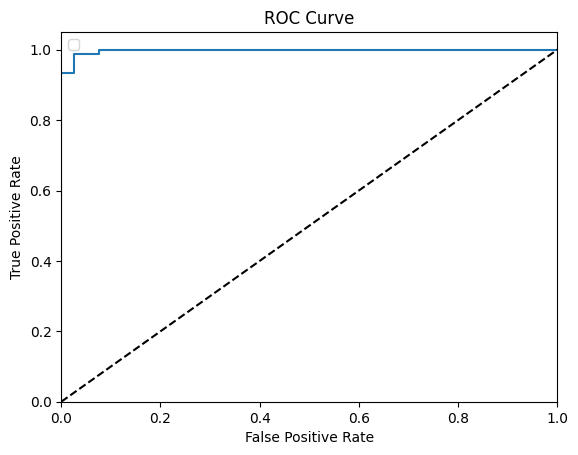

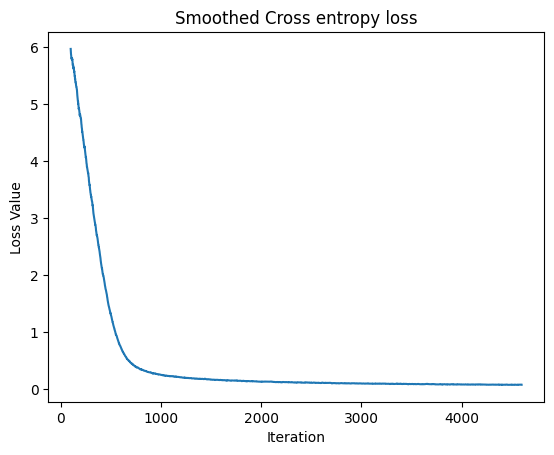

In [15]:
loss_history = SGD(X_train, y_train, my_clf, ce_loss, opt=opt, 
                      batch_size=20, 
                      n_epochs=200
                  )


probas = my_clf.predict(X_test)
my_preds = probas > 0.5
accuracy = accuracy_score(y_test, my_preds)

print(f"My Logistic Regression model accuracy = {(accuracy * 100):.2f}%")

plot_roc_curve(y_test, probas)

smoothed_loss_history = [np.mean(loss_history[step - 100: step]) for step in range(len(loss_history))]
plt.plot(smoothed_loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss Value")
plt.title("Smoothed Cross entropy loss")
plt.show()